This is the notebook where I test the same real audio recording data with a NN (neural network) trained to detect bat calls in a 5 ms audio spectrogram representation.

In [1]:
import keras 
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
import numpy as np 
import scipy.io.wavfile as WAV

Using TensorFlow backend.


In [2]:
# load a single channel 'busy' recording : 
filename = 'ch0_2018-07-28_22-06-13_1532804773.wav'
fs, full_audio = WAV.read('wavs/'+filename)
fullaudio_norm = full_audio/(-1.0 + 2**15)

/home/tbeleyur/anaconda2/envs/deeplearning/lib/python2.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [3]:
%matplotlib notebook

<IPython.core.display.Javascript object>


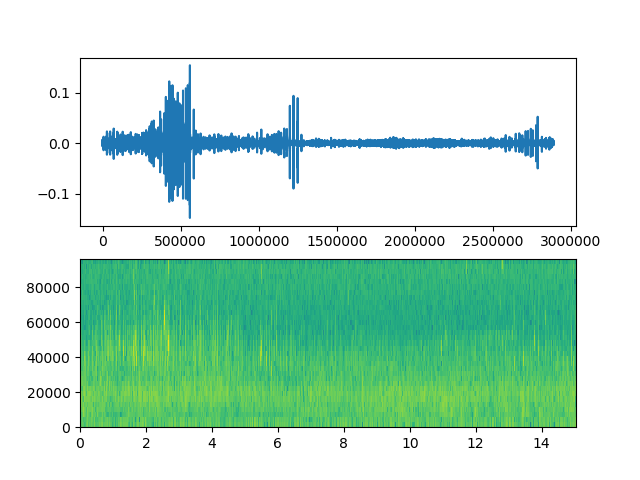

In [4]:
plt.figure()
plt.subplot(211)
plt.plot(fullaudio_norm)
plt.subplot(212)
s,f,t,im = plt.specgram(fullaudio_norm, Fs=fs, NFFT=64, noverlap=40,)

<IPython.core.display.Javascript object>


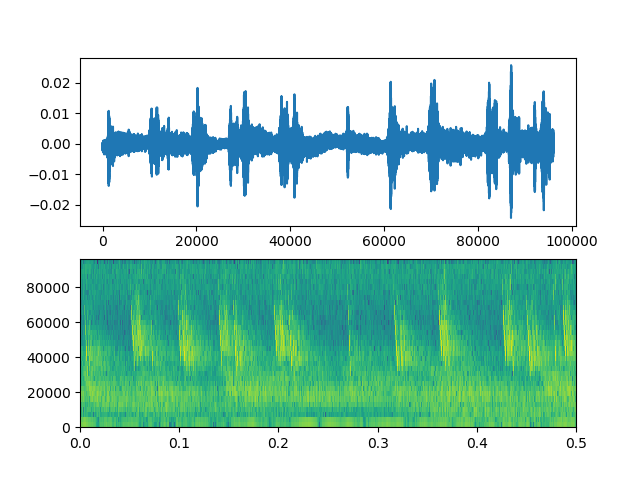

In [42]:
# let's take only part of the recording so we can visualise the waveform and spectrograms in detail : 
part_audionorm = fullaudio_norm[192000:192000+96000]
plt.figure()
plt.subplot(211)
plt.plot(part_audionorm)
plt.subplot(212)
S,f,t,im = plt.specgram(part_audionorm, Fs=fs, NFFT=64, noverlap=32);

In [43]:
S.shape

(33, 2999)

In [44]:
2999/59.0

50.83050847457627

In [45]:
# Now let's split the whole spectrogram into tinier 10ms segments, which is what the network was trained 
n_images = 100
ncols = 29
nrows= 33

S_test = np.flipud(S[:,:n_images*ncols])
many_10msclips = np.zeros((n_images, nrows, ncols))
start_inds = np.arange(0,n_images*ncols-30, 30)

for i, start_index in enumerate(start_inds):
    end_index = start_index + 29
    many_10msclips[i,:,:] = S_test[:, start_index:end_index]
    

In [46]:
def normalise_wref_tomax(X):
    max_norm  = (X+10**-15)/np.max(abs(X+10**-15))
    return(max_norm)

In [47]:
# And now let's do the band-wise mean subtraction like we did before:
many10msclips_meansub = np.copy(many_10msclips)
from make_training_data import mean_subtract_rowwise
for i, each_image in enumerate(many_10msclips):
    many10msclips_meansub[i,:,:] = normalise_wref_tomax(mean_subtract_rowwise(each_image))

In [48]:
# Now let's reshape the spectrograms into the required 1d shape, and see what the network predicts !! 
manyclips_for_input = many10msclips_meansub.reshape(-1, nrows*ncols)

#load the pre-trained model:
network = keras.models.load_model('batlikecall_detector_v1_5ms.h5')

In [49]:
probs = network.predict(manyclips_for_input)

<IPython.core.display.Javascript object>


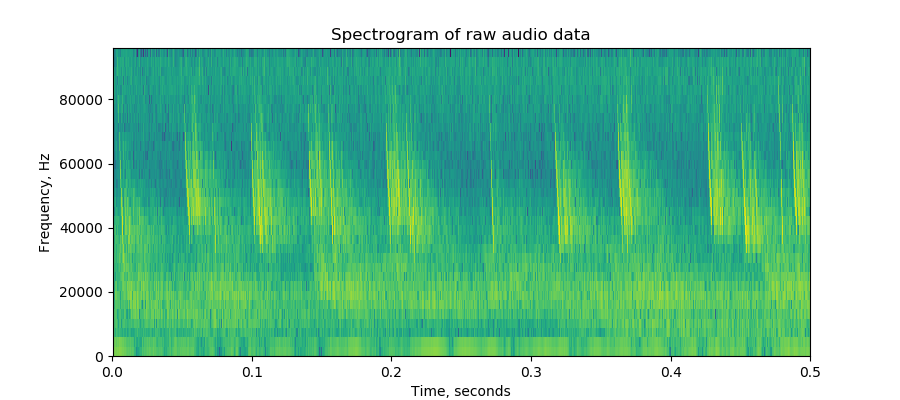

<IPython.core.display.Javascript object>


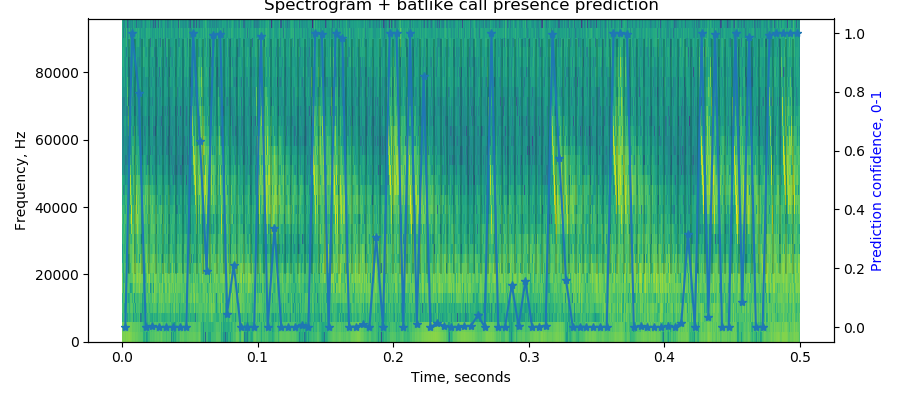

Text(0.5,1,'Spectrogram + batlike call presence prediction')

In [50]:

plt.figure(figsize=(9,4))
plt.specgram(part_audionorm, Fs=fs, NFFT=64, noverlap=32);
plt.xlabel('Time, seconds')
plt.ylabel('Frequency, Hz')
plt.title('Spectrogram of raw audio data')

fig, ax1 = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(9)
S,f,t,im=plt.specgram(part_audionorm, Fs=fs, NFFT=64, noverlap=32)
for seg in np.arange(0.005,0.5,0.005):
    plt.vlines(seg,20000,90000, linewidth=0.25)
ax1.set_ylabel('Frequency, Hz')
ax1.set_xlabel('Time, seconds')

ax2 = ax1.twinx()
ax2.plot(np.arange(0.0025,0.5025,0.005)[:probs[:,1].size], probs[:,1],'-*')
ax2.set_ylabel('Prediction confidence, 0-1', color='blue')
fig.tight_layout()
plt.title('Spectrogram + batlike call presence prediction')

### Concluding remarks: 
The 5ms detector does a pretty decent job too when fed in separate spectrogram windows, but I can see where it fails:
* 1) multiple calls in a window : the network has *not* been trained on multi-call windows
* 2) harmonics in a call : I have a feeling the network may not be able to generalise a 'two-lined' bat call to a 'single-lined' mono-harmonic sweep. 


In [51]:
# Let's try and do the non-overlaping spectrogram input :
step_size = 10 
overlapping_start_inds = np.arange(0, S.shape[1]-ncols, step_size)
overlapping_end_inds = overlapping_start_inds + ncols
ovlping_S = np.zeros((overlapping_start_inds.size, nrows, ncols))
window_mids = []
for i, out in enumerate(zip(overlapping_start_inds, overlapping_end_inds)):
    start, end = out 
    mid = int((start+end)/2.0)
    each_image = S[:, start:end]
    ovlping_S[i,:,:] = normalise_wref_tomax(mean_subtract_rowwise(each_image))
    window_mids.append(mid)
    



In [52]:
predn_window_times = t[window_mids]

In [53]:
predn_window_times.shape, ovlping_S.shape

((297,), (297, 33, 29))

In [54]:
overlappingS_input_imgs = ovlping_S.reshape(-1, nrows*ncols)
overlap_prob = network.predict(overlappingS_input_imgs)

<IPython.core.display.Javascript object>


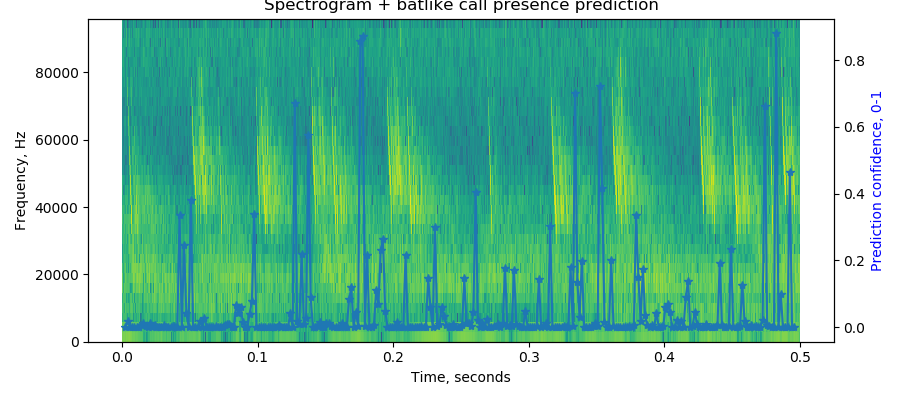

Text(0.5,1,'Spectrogram + batlike call presence prediction')

In [55]:
fig, ax1 = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(9)
plt.specgram(part_audionorm, Fs=fs, NFFT=64, noverlap=32);
ax1.set_ylabel('Frequency, Hz')
ax1.set_xlabel('Time, seconds')

ax2 = ax1.twinx()
ax2.plot(predn_window_times, overlap_prob[:,1],'-*')
ax2.set_ylabel('Prediction confidence, 0-1', color='blue')
fig.tight_layout()
plt.title('Spectrogram + batlike call presence prediction')

I find it funny that the overlapping spectrogram detection is actually doing a rather bad job - I thought if anything at all, it would do a better job. This is because the network has more 'chances' to see a call in the midst of the reverb/noise/etc, and thus expected a smooth peak. But I'm still wondering till now, if I'm plotting the time-axis right, or if there's something else wrong in my code...?

### Testing how the CNN does with the same spectrogram data : 


In [56]:
cnn_5ms = keras.models.load_model('batlikecall_detector_v2CNN_5ms.h5')


In [57]:
ovlpS_cnncomp = ovlping_S.reshape(ovlping_S.shape[0], nrows, ncols,1)
nonovlpS_cnncomp = manyclips_for_input.reshape(manyclips_for_input.shape[0], nrows, ncols, 1)

In [58]:
probs_ovlpcnn = cnn_5ms.predict(ovlpS_cnncomp)
probs_nonovlpcnn = cnn_5ms.predict(nonovlpS_cnncomp)

<IPython.core.display.Javascript object>


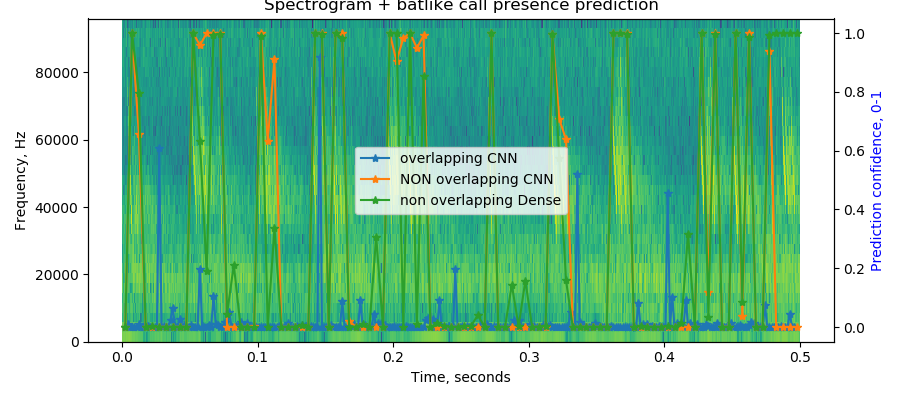

In [59]:
fig, ax1 = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(9)
plt.specgram(part_audionorm, Fs=fs, NFFT=64, noverlap=32);
ax1.set_ylabel('Frequency, Hz')
ax1.set_xlabel('Time, seconds')

ax2 = ax1.twinx()
ax2.plot(predn_window_times, probs_ovlpcnn[:,1],'-*', label='overlapping CNN')
ax2.plot(np.arange(0.0025,0.5025,0.005)[:probs_nonovlpcnn[:,1].size], probs_nonovlpcnn[:,1],'-*', label='NON overlapping CNN')
ax2.plot(np.arange(0.0025,0.5025,0.005)[:probs[:,1].size], probs[:,1],'-*',label='non overlapping Dense')

ax2.set_ylabel('Prediction confidence, 0-1', color='blue')
fig.tight_layout()
plt.title('Spectrogram + batlike call presence prediction');plt.legend()

In [60]:
probs_nonovlpcnn[:,1].size

100